<a href="https://colab.research.google.com/github/kaizu/ecell4_docs/blob/latest/en/tutorials/tutorial01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kaizu/ecell4_docs/blob/latest/en/tutorials/tutorial01.ipynb)

In [0]:
!pip install -r https://github.com/kaizu/ecell4_docs/raw/latest/en/requirements.txt
# Restart the colab kernel before running the following.

     |████████████████████████████████| 194kB 2.7MB/s 
     |████████████████████████████████| 31.9MB 141kB/s 
Obtaining ecell4 from git+https://github.com/kaizu/ecell4.git@v1.2.0#egg=ecell4 (from -r https://github.com/kaizu/ecell4_docs/raw/latest/en/requirements.txt (line 4))
  Cloning https://github.com/kaizu/ecell4.git (to revision v1.2.0) to ./src/ecell4
  Running command git clone -q https://github.com/kaizu/ecell4.git /content/src/ecell4
  Running command git checkout -b v1.2.0 --track origin/v1.2.0
  Switched to a new branch 'v1.2.0'
  Branch 'v1.2.0' set up to track remote branch 'v1.2.0' from 'origin'.
  Running setup.py develop for ecell4


# 1. Brief Tour of E-Cell4 Simulations

First of all, you have to load the E-Cell4 library:


In [0]:
%matplotlib inline
from ecell4.prelude import *

## 1.1. Quick Demo

There are three fundamental components consisting of E-Cell System version 4, which are `Model`, `World`, and `Simulator`. These components describe concepts in simulation.

* `Model` describes a problem to simulate as its name suggests.  
* `World` describes a state, e.g. an initial state and a state at a time-point.  
* `Simulator` describes a solver.

`Model` is independent from solvers. Every solver can share a single `Model` instance. Each solver alogrithm has a corresponding pair of `World` and `Simulator` (these pairs are capsulized into `Factory` class). `World` is not necessarily needed to be bound to `Model` and `Simulator`, but `Simulator` needs both `Model` and `World`.

Before running a simulation, you have to make a `Model`. E-Cell4 supports multiple ways to buld a `Model` (See **2. How to Build a Model** [local ipynb](tutorial2.ipynb) [readthedocs](http://ecell4.readthedocs.io/en/latest/tutorials/tutorial2.html)). Here, we explain the simplest way using the `with` statement with `reaction_rules`:

In [0]:
with reaction_rules():
    A + B > C | 0.01  # equivalent to create_binding_reaction_rule
    C > A + B | 0.3   # equivalent to create_unbinding_reaction_rule

m1 = get_model()
show(m1)


A + B > C | 0.01
C > A + B | 0.3


Please remember to write parentheses `()` after `reaction_rules`. Here, a `Model` with two `ReactionRule`s named `m1` was built. Lines in the `with` block describe `ReactionRule`s, a binding and unbinding reaction respectively. A kinetic rate for the mass action reaction is defined after a separator `|`, i.e. `0.01` or `0.3`. In the form of ordinary differential equations, this model can be described as:

$$[\mathrm{A}]'=[\mathrm{B}]'=-[\mathrm{C}]=-0.01[\mathrm{A}][\mathrm{B}]+0.3[\mathrm{C}]$$

For more compact description, `A + B == C | (0.01, 0.3)` is also acceptable.

E-Cell4 has a simple interface for running simulation on a given model, called `run_simulation`. This enables for you to run simulations without instanciate `World` and `Simulator` by yourself. To solve this model, you have to give a volume, an initial value for each `Species` and duration of time:

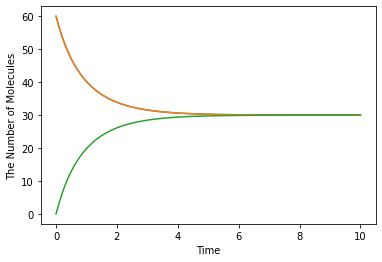

In [0]:
run_simulation(10.0, model=m1, y0={'A': 60, 'B': 60}, volume=1.0)

To switch simulation algorithm, you only need to give the type of solver (`ode` is used as a default) as follows:

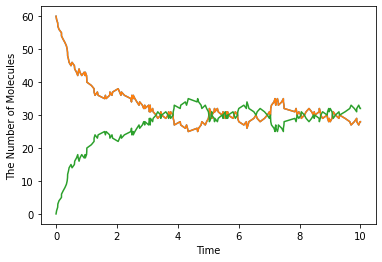

In [0]:
run_simulation(10.0, model=m1, y0={'A': 60, 'B': 60}, solver='gillespie')

## 1.2. Spatial Simulation and Visualization

E-Cell4 now supports multiple spatial simulation algorithms, `egfrd`, `spatiocyte` and `meso`. In addition to the model used in non-spatial solvers (`ode` and `gillespie`), these spatial solvers need extra information about each `Species`, i.e. a diffusion coefficient and radius.

The `with` statement with `species_attributes` is available to describe these properties:

In [0]:
with species_attributes():
    A | B | C | {'radius': 0.005, 'D': 1}  # 'D' is for the diffusion coefficient

with reaction_rules():
    A + B == C | (0.01, 0.3)

m2 = get_model()

Species attributes could be a string, boolean, integer or floating number.

Now you can run a spatial simulation in the same way as above (in the case of `egfrd`, the time it takes to finish the simulation will be longer):

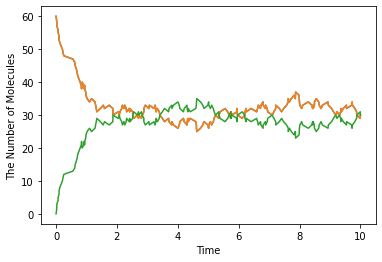

In [0]:
run_simulation(10.0, model=m2, y0={'A': 60, 'B': 60}, solver='meso')

Structure (e.g. membrane, cytoplasm and nucleus) is only supported by `spatiocyte` and `meso` for now. For the simulation, `location` and `dimension` that each species belongs to must be specified in its attribute.

In [0]:
with species_attributes():
    A | {'D': 1, 'location': 'S', 'dimension': 3}  # 'S' is a name of the structure
    S | {'dimension': 3}

m3 = get_model()  # with no reactions

E-Cell4 supports primitive shapes as a structure like `Sphere`:

In [0]:
sphere = Sphere(Real3(0.5, 0.5, 0.5), 0.48)  # a center position and radius

E-Cell4 provides various kinds of `Observer`s which log the state during a simulation. In the following two observers are declared to record the position of the molecule. `FixedIntervalTrajectoryObserver` logs a trajectory of a molecule, and `FixedIntervalHDF5Observer` saves `World` to a HDF5 file at the given time interval:

In [0]:
obs1 = FixedIntervalTrajectoryObserver(1e-3)
obs2 = FixedIntervalHDF5Observer(0.1, 'test%02d.h5')

`run_simulation` can accept structures and observers as arguments `structure` and `observers` (see also `help(run_simulation)`):

In [0]:
_ = run_simulation(1.0, model=m3, y0={'A': 60}, structures={'S': sphere}, solver='spatiocyte', observers=(obs1, obs2))

E-Cell4 has a function to visualize the world which is also capable of interactive visualization named `viz.plot_world`. `viz.plot_world` plots positions of molecules in 3D. In addition, by using `load_world`, you can easily restore the state of `World` from a HDF5 file:

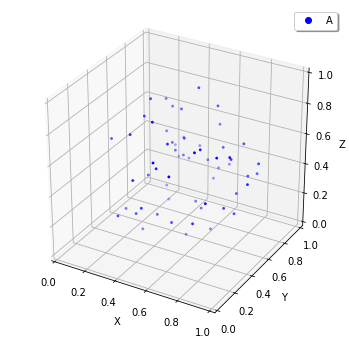

In [0]:
plotting.plot_world(load_world('test00.h5'), species_list=['A'])

Also, for `FixedIntervalTrajectoryObserver`,` viz.plot_trajectory` generates a plot of the trajectory. (Again, it is possible to generate interactive plots.):

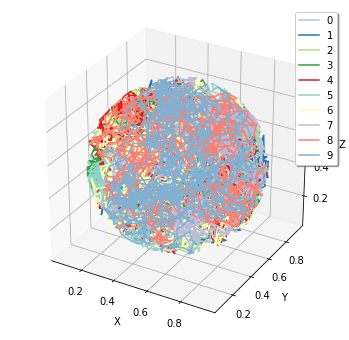

In [0]:
plotting.plot_trajectory(obs1)

For more details, see [5. How to Log and Visualize Simulations](tutorial05.html).